In [1]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from tensorflow.keras.utils import plot_model

In [2]:
from model import InceptionNet_LSTM, inception_model
from utils import add_end_start_tokens, clean_bad_text_data, create_vocab, _extract_feature

In [3]:
with open('process_data/image_captoin_mapping_clean.pkl','rb') as f:
    image_captoin_mapping_clean= pickle.load(f)

image_captoin_mapping_with_token = add_end_start_tokens(image_captoin_mapping_clean)

vocab = create_vocab(image_captoin_mapping_with_token)
vocab[0:15]

['<start>',
 'a',
 'very',
 'clean',
 'and',
 'well',
 'decorated',
 'empty',
 'bathroom',
 '<end>',
 'blue',
 'white',
 'with',
 'butterfly',
 'themed']

In [4]:
with open('process_data/max_length.pkl','rb') as f:
    max_length = pickle.load(f)
max_length

15

In [5]:
inception_lstm = InceptionNet_LSTM(vocab)
model = inception_lstm.build_model(max_length=max_length)

In [6]:
plot_model(model, to_file='model.png', show_shapes=True)

## Compare feature vector between InceptionNet V3 and HOG

In [7]:
def co_sim(a, b):
    """
    cosine similarity function to measure similarity of 2 feature vectors
    """
    return np.dot(a, b)/(norm(a)*norm(b))

In [15]:
def hog_model():
    cell_size = (8, 8)
    block_size = (2, 2)
    nbins = 9 # number of orientation bins
    img_size = (64,128)
    winSize = (img_size[1] // cell_size[1] * cell_size[1], img_size[0] // cell_size[0] * cell_size[0])
    blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
    blockStride = (cell_size[1], cell_size[0])
    n_cells = (img_size[0] // cell_size[0], img_size[1] // cell_size[1])
    hog = cv2.HOGDescriptor(_winSize=winSize,
                        _blockSize=blockSize,
                        _blockStride=blockStride,
                        _cellSize=cell_size,
                        _nbins=nbins)
    return hog

In [9]:
def _extract_hog_feature(path, hog_model, img_size=(128,64)):
    block_size = (2, 2)
    nbins = 9
    n_cells = (8, 16)
    img = cv2.imread(path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feats = hog_model.compute(img).reshape(n_cells[1] - block_size[1] + 1,
                                    n_cells[0] - block_size[0] + 1,
                                    block_size[0], block_size[1], nbins).transpose((1, 0, 2, 3, 4))
    hog_feats = hog_feats.flatten()
    return hog_feats 

In [42]:
def _show_pair_image(base_url, list_pair, title = '', **kwargs):
    show_image_size = (200, 200)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7),subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        img1 = cv2.imread(base_url + '/' + list_pair[i][0])
        img2 = cv2.imread(base_url + '/' + list_pair[i][1])
        img1 = cv2.resize(img1, show_image_size)
        img2 = cv2.resize(img2, show_image_size)
        im_h = cv2.hconcat([img1, img2])
        im_h = cv2.cvtColor(im_h, cv2.COLOR_BGR2RGB)
        _inception_cs = kwargs.get('inception_co_sim', None)
        _hog_cs = kwargs.get('hog_co_sim', None)
        if _inception_cs:
            ax.set_title(f'InceptionNet : {str(round(_inception_cs[i], 2))}', loc='left')
        if _hog_cs:
            ax.set_title(f'HOG : {str(round(_hog_cs[i], 2))}', loc='right')
        ax.imshow(im_h)
    plt.tight_layout()
    fig.suptitle(title, fontsize=20)
    plt.show()

In [55]:
base_url = 'data/image_compare'
# Pair image
similar_pair_image = [('pair_1_1.jpg', 'pair_1_2.jpg'), ('pair_2_1.jpg', 'pair_2_2.png'), ('pair_3_1.jpg', 'pair_3_2.jpg'), ('pair_4_1.jpg', 'pair_4_2.jpg'), ('pair_5_1.jpg', 'pair_5_2.jpg'), ('pair_6_1.png', 'pair_6_2.png')]
totally_different_pair_image = [('pair_7_1.png', 'pair_7_2.png'), ('pair_8_1.png', 'pair_8_2.jpg'), ('pair_9_1.jpg', 'pair_9_2.jpg'), ('pair_10_1.jpg', 'pair_10_2.jpg'), ('pair_11_1.jpg', 'pair_11_2.jpg'), ('pair_12_1.jpg', 'pair_12_2.png')]

In [56]:
_show_pair_image(base_url, similar_pair_image, 'Similar pair image')

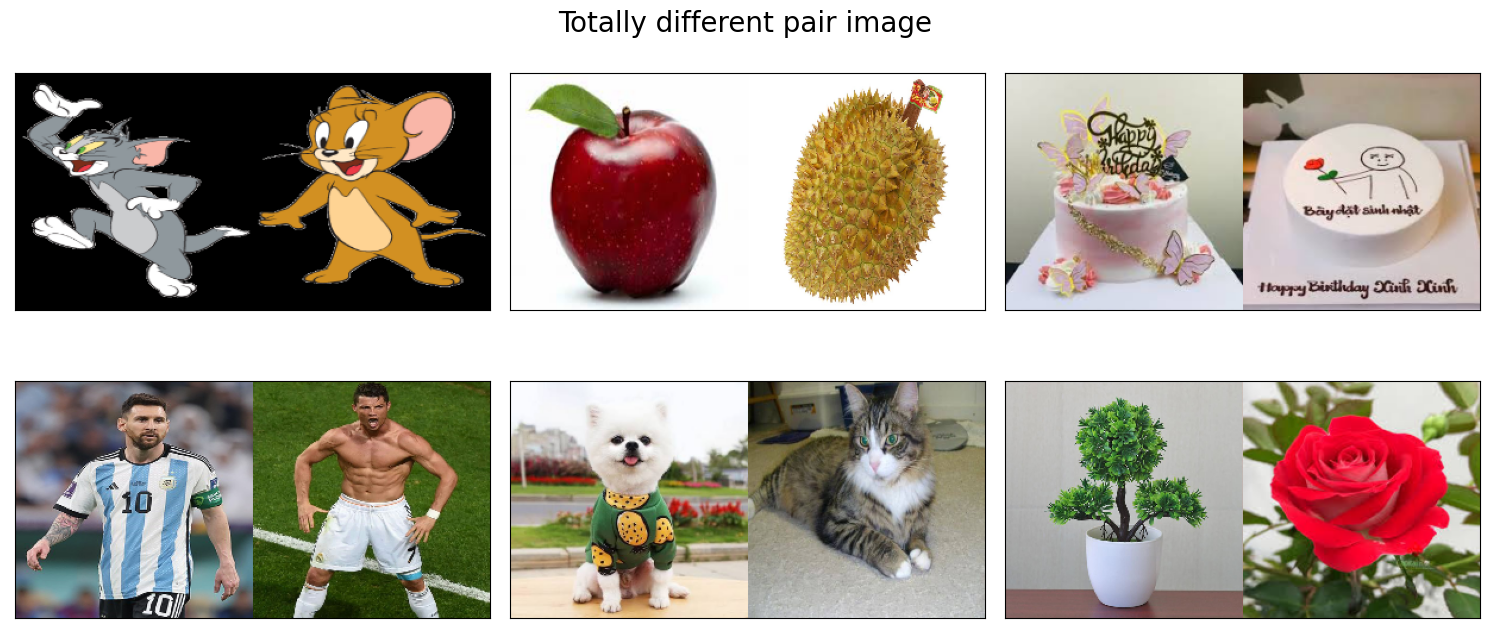

In [57]:
_show_pair_image(base_url, totally_different_pair_image, 'Totally different pair image')

In [44]:
# Inception Net model
_inception_net_model = inception_model()

# Hog model
_hog_model = hog_model()

In [64]:
def _get_cosim_value(base_url, list_pair):
    hog_cosim_value = {}
    inception_cosim_value = {}
    for i in range(1, len(list_pair) + 1):
        hog_cosim_value[f'pair_{i}'] = co_sim(_extract_hog_feature(base_url + '/' + list_pair[i-1][0], _hog_model), _extract_hog_feature(base_url + '/' + list_pair[i-1][1], _hog_model))
        inception_cosim_value[f'pair_{i}'] = co_sim(_extract_feature(base_url + '/' + list_pair[i-1][0], _inception_net_model), _extract_feature(base_url + '/' + list_pair[i-1][1], _inception_net_model))
    return hog_cosim_value, inception_cosim_value


In [65]:
similar_hog_cosim_value, similar_inception_cosim_value = _get_cosim_value(base_url, similar_pair_image)

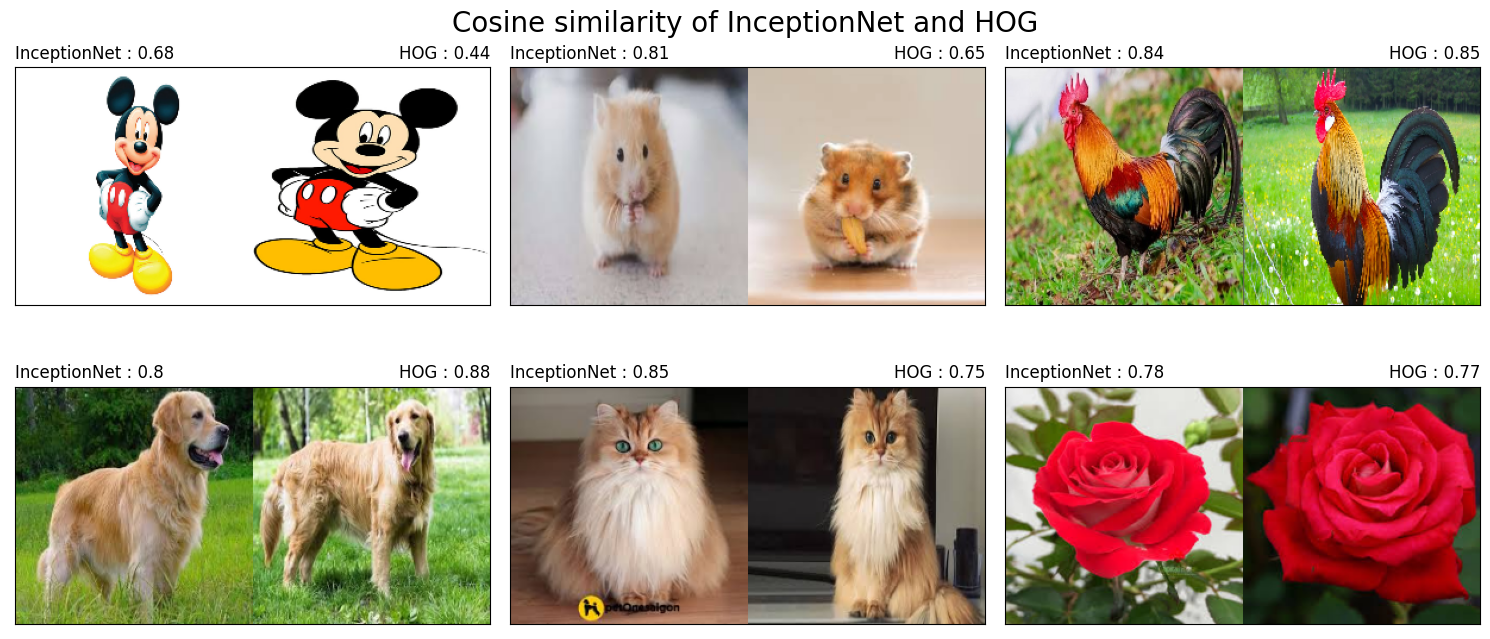

In [66]:
_show_pair_image(base_url, similar_pair_image, 'Cosine similarity of InceptionNet and HOG', hog_co_sim=list(similar_hog_cosim_value.values()), inception_co_sim=list(similar_inception_cosim_value.values()))

In [67]:
diff_hog_cosim_value, diff_inception_cosim_value = _get_cosim_value(base_url, totally_different_pair_image)

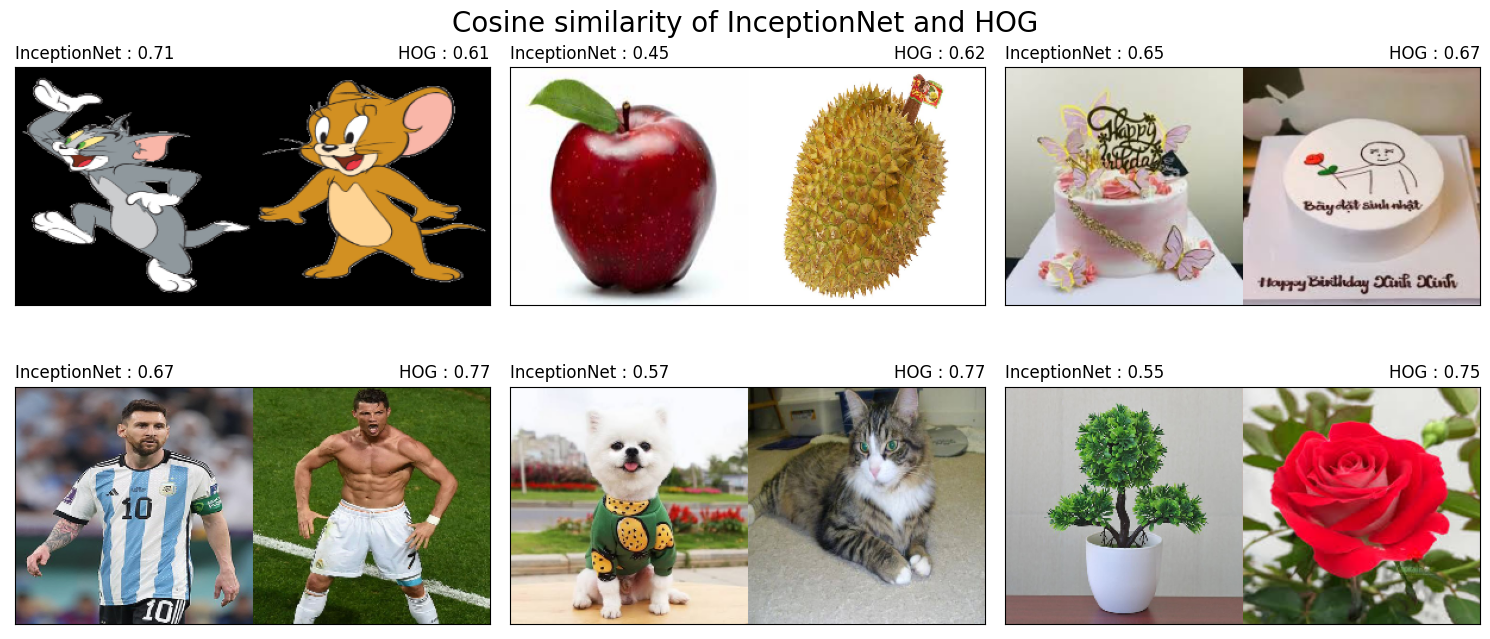

In [68]:
_show_pair_image(base_url, totally_different_pair_image, 'Cosine similarity of InceptionNet and HOG', hog_co_sim=list(diff_hog_cosim_value.values()), inception_co_sim=list(diff_inception_cosim_value.values()))

In [104]:

def eva_lot(x, y, title, sub_title, legends=['HOG', 'InceptionNet']):
    plt.figure(figsize = (12,6), dpi = 80)
    plt.plot(x, y[0], marker='o')
    plt.plot(x, y[1], marker='o')
    plt.title(sub_title, fontsize=14)
    plt.suptitle(title, y=0.99, fontsize=18)
    plt.xlabel('Pair images')
    plt.ylabel('Co-sin value')
    plt.legend(legends, loc=4)
    plt.grid(color='0.9')
    plt.show()

In [106]:
eva_lot(list(similar_hog_cosim_value.keys()), [list(similar_hog_cosim_value.values()), list(similar_inception_cosim_value.values())], 'Cosine similarity of InceptionNet and HOG', 'The bigger the better')

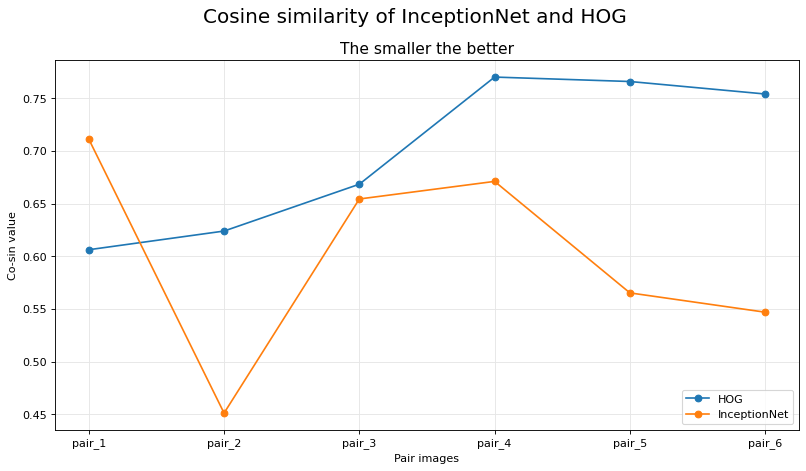

In [107]:
eva_lot(list(diff_hog_cosim_value.keys()), [list(diff_hog_cosim_value.values()), list(diff_inception_cosim_value.values())], 'Cosine similarity of InceptionNet and HOG', 'The smaller the better')

## Evaluate Model

In [10]:
import keras
import pickle
from evaluate import evaluate_model

from utils import add_end_start_tokens, train_test_split

In [13]:
weight_folder = 'weights/'

In [11]:
with open('process_data/image_captoin_mapping_clean.pkl','rb') as f:
    image_captoin_mapping_clean= pickle.load(f)

image_captoin_mapping_with_token = add_end_start_tokens(image_captoin_mapping_clean)

train_data, test_data = train_test_split(image_captoin_mapping_with_token)

### Single Model (InceptionNet and LSTM)

In [16]:
with open(f'process_data/test_features.pkl','rb') as f:
    test_features= pickle.load(f)

model = keras.models.load_model(f'{weight_folder}model_{28}.h5', compile=False)
evaluate_model(model, test_data, test_features)

d:\WorkSpace\ComputerVision\ImageCaptioning\venv\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: model is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
d:\WorkSpace\ComputerVision\ImageCaptioning\venv\lib\site-packages\keras\layers\core\lambda_layer.py:307: UserWarning: model is not loaded, but a Lambda layer uses it. It may cause errors.
  output_shape = cls._parse_function_from_config(config, custom_objects,


TypeError: unhashable type: 'slice'

## Dual Model (InceptionNet, LSTM and YOLOv4)

In [ ]:
with open(f'process_data/test_combine_features.pkl','rb') as f:
    test_features= pickle.load(f)

model = keras.models.load_model(f'{weight_folder}model_{28}_dual.h5', compile=False)
evaluate_model(model, test_data, test_features)

In [19]:
with open(f'process_data/test_features.pkl','rb') as f:
    test_features= pickle.load(f)

with open(f'process_data/train_features.pkl','rb') as f:
    train_features= pickle.load(f)

In [20]:
(len(train_features), len(test_features))

(74504, 8279)